In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
!pip install xgboost

## Import and check data

In [17]:
save_folder = 'CleanedData/'

# Read all data
data = []
for fname in os.listdir(save_folder):
    data.append(pd.read_csv(save_folder + fname))
data = pd.concat(data)

# View data
data.sort_values(by=['Total WAR','year','vote_points'], ascending=False).head()

,player_id,last_name,first_name,year,player_age,rank,vote_points,1st_place,mvp_share,Total WAR,...,xba,xslg,woba,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate
56,605141,Betts,Mookie,2018,26,1,410,28,0,10.68,...,0.309,0.604,0.449,0.430,0.410,0.295,92.2,18.5,39.4,14.1
660,545361,Trout,Mike,2012,21,2,281,6,0,10.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,594798,deGrom,Jacob,2018,30,5,141,1,0,10.36,...,0.140,0.172,0.180,0.172,0.194,0.032,82.1,7.7,20.0,0.0
602,545361,Trout,Mike,2018,27,2,265,1,0,9.92,...,0.294,0.599,0.447,0.434,0.446,0.305,91.2,18.6,41.3,16.8
277,547180,Harper,Bryce,2015,23,1,420,30,1,9.74,...,0.294,0.551,0.461,0.421,0.435,0.257,91.4,14.8,37.3,13.2


## Split and balance data

In [5]:
# Split data
# Train on 2008-2017; keep 2018+ for "testing"
train_data = data.loc[data.year >= 2018]
val_data = data.loc[data.year == 2018]

train_data.shape, val_data.shape

((2658, 39), (665, 39))

In [6]:
# No data balancing required - regression exercise, not classification

## Feature engineering (?)

In [17]:
# Isolate most important batter stats

data.columns

# Add full name as a column
data['player_name'] = data.apply(lambda row: '{} {}'.format(row['first_name'], row['last_name']), 
                                   axis=1)

# # Identify names of columns denoting key statistics [hard-coded from observation]
id_columns = ['last_name', 'first_name', 'player_name', 'year', 'player_age']
key_stats = ['b_ab', 'b_total_pa', 'b_total_hits', 'b_home_run', 'b_bb_percent', 'batting_avg', 'slg_percent',
             'on_base_percent', 'b_game', 'r_run'
            ]

stats = data[id_columns + key_stats]

stats.head()

,last_name,first_name,player_name,year,player_age,b_ab,b_total_pa,b_total_hits,b_home_run,b_bb_percent,batting_avg,slg_percent,on_base_percent,b_game,r_run
344,Johnson,Nick,Nick Johnson,2008,30,109,147,24,5,22.4,0.220,0.431,0.415,38,15
297,Herrera,Jonathan,Jonathan Herrera,2008,24,61,66,14,0,6.1,0.230,0.279,0.273,28,5
296,Hernandez,Anderson,Anderson Hernandez,2008,26,81,91,27,0,11.0,0.333,0.383,0.407,28,11
295,Hernandez,Livan,Livan Hernandez,2008,33,19,22,5,0,0.0,0.263,0.263,0.227,9,1
294,Hernandez,Michel,Michel Hernandez,2008,30,15,15,3,0,0.0,0.200,0.200,0.200,5,2


## EDA

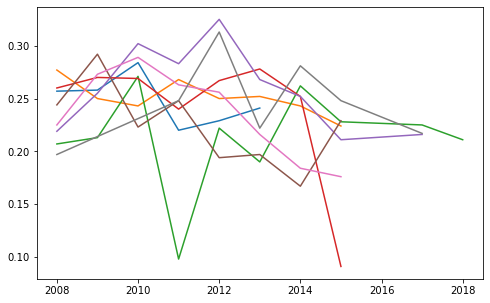

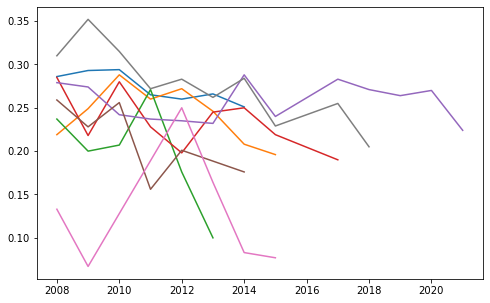

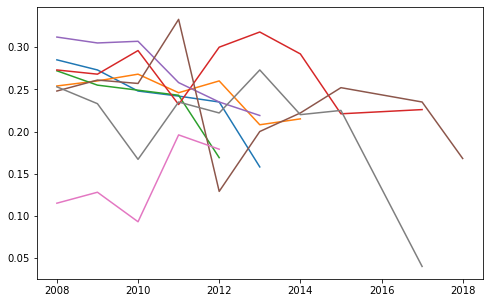

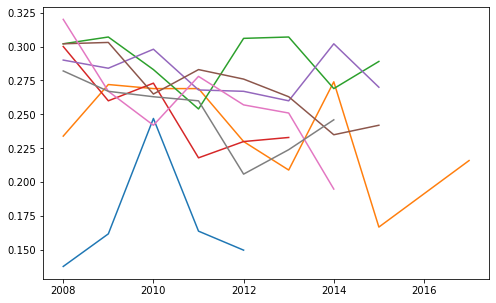

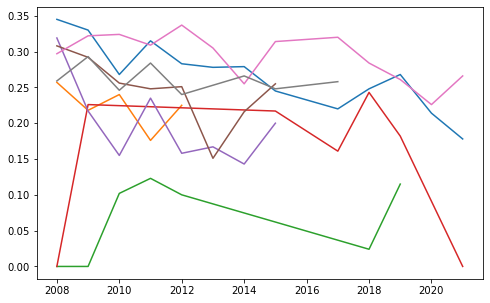

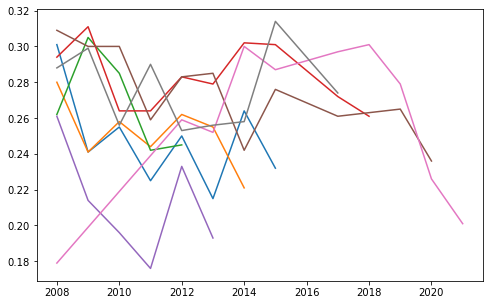

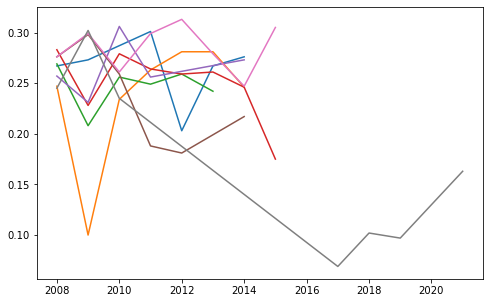

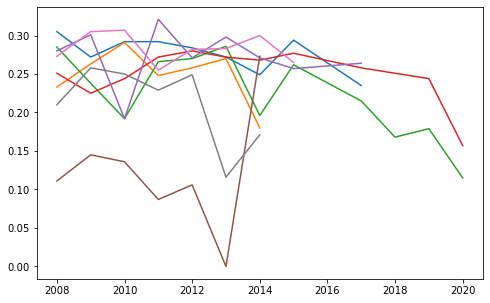

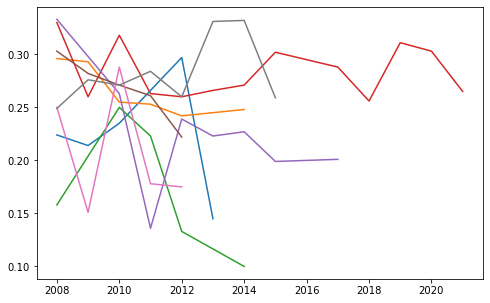

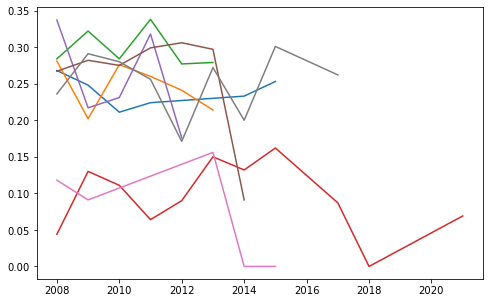

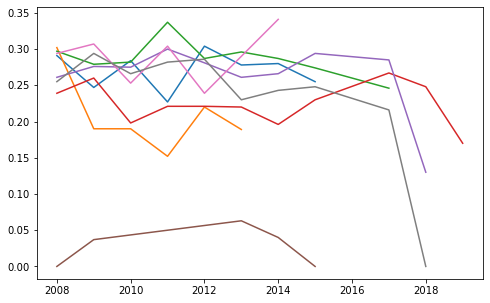

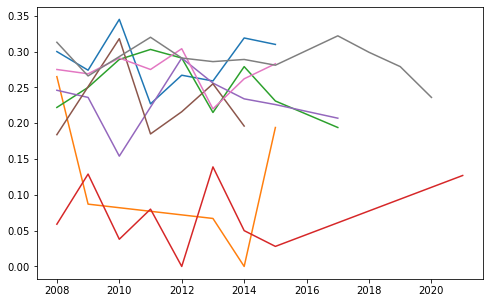

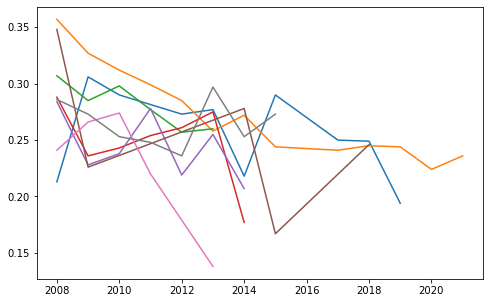

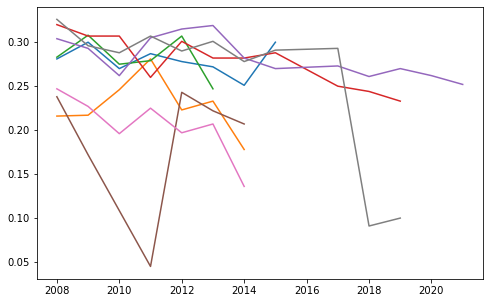

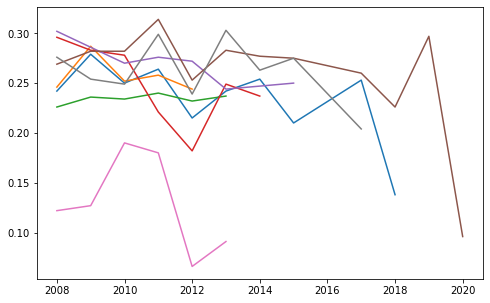

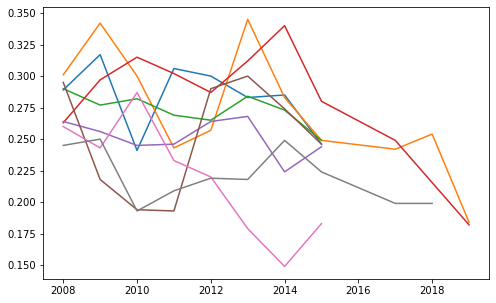

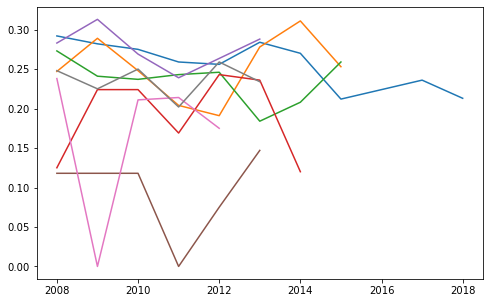

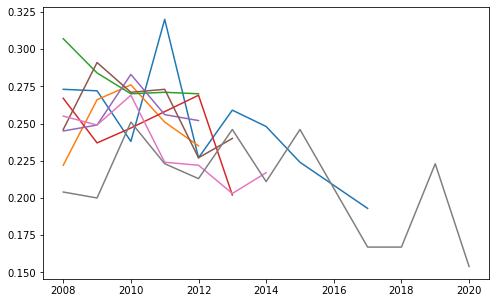

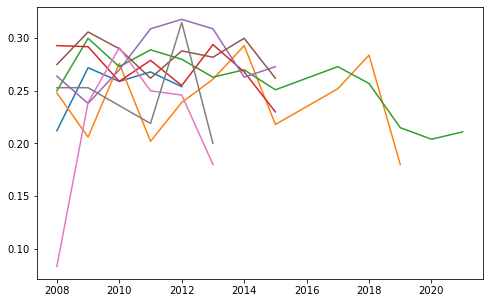

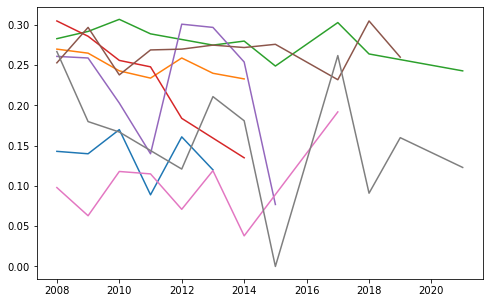

<Figure size 576x360 with 0 Axes>

In [27]:
# ??? Plot stuff?

stats = stats.sort_values(by='year', ascending=True)

plt.figure(figsize=(8,5))

n = 0
for player in stats.player_name.unique():
    # Plot only players with fewer than 4 years of data
    if len(stats.loc[stats.player_name==player]['year'].unique()) < 5:
        continue
    
    plt.plot(stats.loc[stats.player_name==player, 'year'], # X
             stats.loc[stats.player_name==player, 'batting_avg'], #y
             label = player
            )
    # For readability, create a new figure every 8 players
    n += 1
    if n % 8 == 0:
#         plt.legend(loc='best')
        plt.show()  # show current figure
        plt.figure(figsize=(8,5))  # create new figure
    # Stop plotting when 20 plots are created
    if n+1 > 20*8:
        break

# plt.legend()
plt.show()

In [13]:
# How are years of available data distributed for current [2018] players?
curr_players = pd.Series('', index=data.loc[data.year == 2018, 'player_name'].unique())

curr_players = data.groupby('player_name')[['player_name', 'year']].agg(years_played=('year', 'count')).reset_index()
curr_players = curr_players.loc[curr_players['player_name'].isin(data.loc[data.year==2018, 'player_name'])]

curr_players.head()

,player_name,years_played
2,A.J. Ellis,10
6,AJ Pollock,7
8,Aaron Altherr,5
14,Aaron Hicks,9
16,Aaron Judge,5


<AxesSubplot:ylabel='Frequency'>

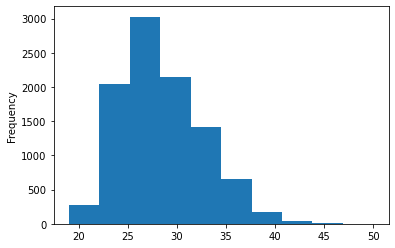

In [33]:
# Plot distribution of player ages
stats['player_age'].plot(kind='hist')

665 players in curr_players; 665 players counted in years_distribution


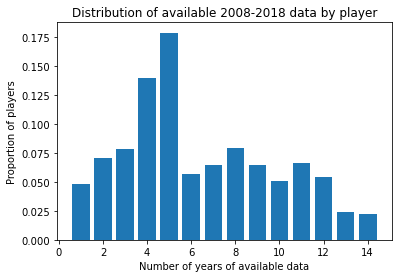

In [15]:
# Plot distribution of players' years of available data
years_distribution = curr_players.groupby('years_played').agg(num_players=('years_played', 'count')).reset_index()
years_distribution['percent_players'] = years_distribution['num_players'] / years_distribution['num_players'].sum()

# Check that all players are included
print('{} players in curr_players; {} players counted in years_distribution'.format(len(curr_players), 
                                                                                   years_distribution['num_players'].sum()))

# Plot
plt.bar(years_distribution['years_played'], years_distribution['percent_players'])
plt.title('Distribution of available 2008-2018 data by player')
plt.xlabel('Number of years of available data')
plt.ylabel('Proportion of players')
plt.show()

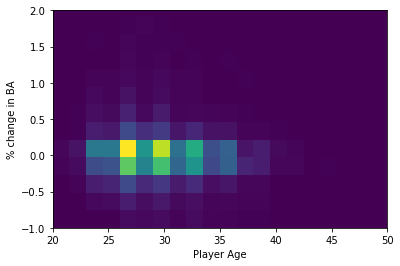

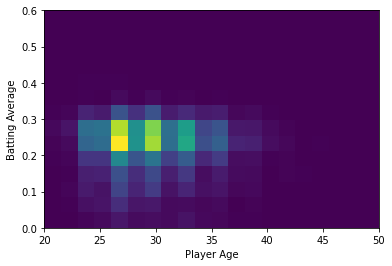

In [176]:
# Are there any relationships between previous BA, current BA, and player age?

# Prepare data - isolate key stats
ba_eda = stats[['player_name', 'player_age', 'batting_avg', 'year']]
ba_eda = ba_eda.sort_values(by='year', ascending=True)

# # lag batting average to get feature vs target
# # note: due to train/test split, some valid data will be omitted
ba_eda['prev_batting_avg'] = ba_eda.groupby('player_name')['batting_avg'].shift()
ba_eda = ba_eda.dropna()

# # calculate %change in BA
ba_eda['ba_change'] = np.divide(np.subtract(ba_eda['batting_avg'], ba_eda['prev_batting_avg']),
                                ba_eda['prev_batting_avg'])
# # clean: replace inf, nan with 0
ba_eda['ba_change'] = ba_eda['ba_change'].fillna(0)
ba_eda.loc[ba_eda['ba_change']==np.inf, 'ba_change'] = 0

# Plot BA change vs. player age
plt.figure()
plt.hist2d(ba_eda['player_age'], ba_eda['ba_change'], bins=(20, 30))
plt.xlabel('Player Age')
plt.ylabel('% change in BA')
plt.ylim([-1, 2])
plt.show()

# Plot BA vs. player age
plt.figure()
plt.hist2d(ba_eda['player_age'], ba_eda['batting_avg'], bins=(20, 15))
plt.xlabel('Player Age')
plt.ylabel('Batting Average')
plt.ylim([0, 0.6])
plt.show()

## Split data

In [64]:
# Split data
# Train on 2008-2017; keep 2018+ for "testing"
train_stats = stats.loc[stats.year <= 2018]
val_stats = stats.loc[stats.year > 2018]

train_stats.shape, val_stats.shape

((7803, 15), (1993, 15))

## Helper functions

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

# Calculate RMSE
def calc_rmse(y_true, y_pred):
    errors = np.subtract(y_true, y_pred)
    return np.sqrt(np.mean(errors ** 2))

# Get accuracy from y_pred, y_true
def get_accuracy(model, X_data, y_data, data_split='Training'):
    # Get predictions
    y_pred = model.predict(X_data)
    
    # Get accuracy from training data
    y_true = y_data.copy()
    acc = calc_rmse(y_true, y_pred).sum()
    
    # Display and return results
    print('{} Accuracy: {:.3f}'.format(data_split.capitalize(), acc))
    return acc


# Get R squared
def get_r2(model, X_data, y_data, data_split='Training'):
    # Get predictions
    y_pred = model.predict(X_data)
    
    # Get R^2
    r2 = r2_score(y_pred, y_data)
    
    print('{} R2 score: {:.3f}'.format(data_split.capitalize(), r2))
    return r2

## Prepare batting average data

In [151]:
# Prepare data - isolate key stats
train_data = train_stats[['player_name', 'player_age', 'batting_avg', 'year']]
train_data = train_data.sort_values(by='year', ascending=True)

# # lag batting average to get feature vs target
# # note: due to train/test split, some valid data will be omitted
train_data['prev_batting_avg'] = train_data.groupby('player_name')['batting_avg'].shift()
train_data = train_data.dropna()

# Check size of training dataset
print('Number of training datapoints:', len(train_data))

train_data.sort_values(by=['player_name','year']).head()

Number of training datapoints: 5768


,player_name,player_age,batting_avg,year,prev_batting_avg
79,A.J. Burnett,36,0.068,2013,0.063
78,A.J. Burnett,37,0.133,2014,0.068
79,A.J. Burnett,38,0.119,2015,0.133
79,A.J. Burnett,38,0.119,2015,0.119
176,A.J. Ellis,29,0.278,2010,0.100


## Clustering

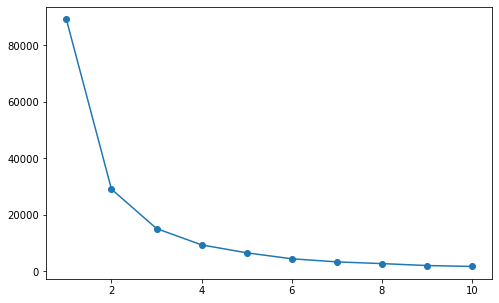

In [136]:
# Cluster based on player age and previous batting average

# Prepare data
kmeans_data = train_data[['player_age', 'prev_batting_avg']]

# Test different numbers of clusters
# Establish a dictionary in which to save all 10 KMeans models
kmeans_dict = {i:'' for i in range(1,11)}

# Loop through all models
for i in range(1, 11):
    kmeans_dict[i] = KMeans(n_clusters = i, random_state = 0).fit(kmeans_data)
    
# Plot inertia for each model
plt.figure(figsize=(8, 5))

plt.plot(list(kmeans_dict.keys()),
         [kmeans_dict[i].inertia_ for i in range(1, 11)],
         marker = 'o'
        )

plt.show()

In [144]:
# Cluster with 5 clusters
kmeans = KMeans(n_clusters = 5)
kmeans.fit(kmeans_data)

# Save labels to kmeans_data
kmeans_data['cluster'] = pd.Series(kmeans.labels_)

kmeans_data.head()

/tmp/ipykernel_115123/2297502788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_data['cluster'] = pd.Series(kmeans.labels_)


,player_age,prev_batting_avg,cluster
306,30,0.274,0
418,33,0.224,1
304,25,0.143,1
305,26,0.274,0
302,32,0.205,0


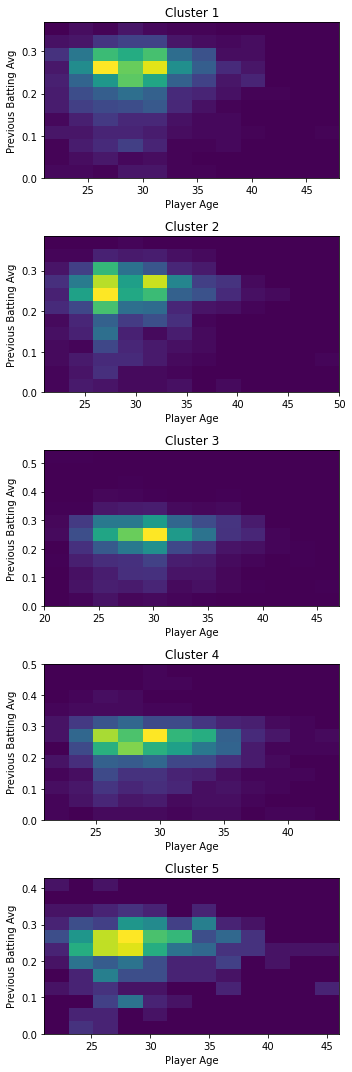

In [159]:
# Plot age, prev_batting_avg distributions for each cluster
plt.figure(figsize=(5,15))
for i in range(5):
    # Plot subplot
    plt.subplot(5, 1, i+1)
    # Plot
    plt.hist2d(kmeans_data.loc[kmeans_data.cluster==i, 'player_age'],
               kmeans_data.loc[kmeans_data.cluster==i, 'prev_batting_avg'],
               bins=(12, 12), 
               label='Cluster {}'.format(i+1)
              )
    # Add labels
    plt.title('Cluster {}'.format(i+1))
    plt.xlabel('Player Age')
    plt.ylabel('Previous Batting Avg')

plt.tight_layout()
plt.show()

## Random Forests

In [103]:
# Test on batting average, using age as a feature
simple_ba_forest = RandomForestRegressor(n_estimators=10, max_depth=5, 
                                         min_samples_split=5, min_samples_leaf=1,
                                         random_state=0)

# Prepare data
X_train = np.array(train_data[['player_age', 'prev_batting_avg']])
y_train = np.array(train_data['batting_avg'])

# Fit
simple_ba_forest.fit(X_train, y_train)

# Predict
y_pred = simple_ba_forest.predict(X_train)

# Get train, val accuracies
train_acc = get_accuracy(simple_ba_forest, X_train, y_train)
train_r2 = get_r2(simple_ba_forest, X_train, y_train)


Training Accuracy: 0.051
Training R2 score: -0.473


In [ ]:
# Develop a separate random forest regressor for each cluster

## XGBoost

In [131]:
# Test on batting average, using age as a feature
simple_xgb = xgb.XGBRegressor(max_depth=20, learning_rate=0.5,
                              n_estimators=20, subsample=0.8, #low subsample = underfit
                              colsample_bytree=1.0, #high colsample = overfit,
                              objective='reg:squarederror',
                              random_state=0)

# Prepare data
X_train = np.array(train_data[['player_age', 'prev_batting_avg']])
y_train = np.array(train_data['batting_avg'])
dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)

# Fit
simple_xgb.fit(X_train, y_train)

# Predict
y_pred = simple_xgb.predict(X_train)

# Get train, val accuracies
train_acc = get_accuracy(simple_xgb, X_train, y_train)
train_r2 = get_r2(simple_xgb, X_train, y_train)


Training Accuracy: 0.038
Training R2 score: 0.540
